In [8]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re


# ---------- GLOBAL STYLE ----------
# Set Times New Roman as the default font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern for math symbols
plt.rcParams['font.size'] = 12  # Base font size
plt.rcParams['axes.labelsize'] = 14  # Font size for axis labels
plt.rcParams['axes.titlesize'] = 14  # Font size for titles
plt.rcParams['xtick.labelsize'] = 12  # Font size for tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size for tick labels
plt.rcParams['legend.fontsize'] = 12  # Font size for legends
# Set default line width for all plots (change this value to adjust thickness)
plt.rcParams['lines.linewidth'] = 0.50


def extract_all_chi2(out_path):
    """
    Return a list of all Chi2 values found in a FullProf .out file.
    """
    out_path = Path(out_path)
    chi2_values = []

    with out_path.open("r", encoding="latin-1", errors="ignore") as f:
        for line in f:
            if "Chi2" in line:
                # Take text after 'Chi2'
                tail = line.split("Chi2", 1)[1]
                # First float-like number in that tail
                m = re.search(r"[-+]?\d*\.?\d+(?:[Ee][-+]?\d+)?", tail)
                if m:
                    chi2_values.append(float(m.group(0)))

    return chi2_values


def print_hkl_ticks(filename):
    phases = {}
    current_phase = 1

    try:
        with open(filename, 'r') as f:
            for line in f:
                parts = line.strip().split()
                
                # 1. Detect Phase Header (e.g., "Phase No: 2")
                if "Phase" in line and "No" in line:
                    try:
                        # Extract the number after "No"
                        import re
                        match = re.search(r'No[:\s]+(\d+)', line)
                        if match:
                            current_phase = int(match.group(1))
                    except:
                        pass
                    continue

                # 2. Parse Data Lines (H K L must be integers)
                if len(parts) > 4:
                    try:
                        # Check if first 3 columns are integers (H K L)
                        h, k, l = int(parts[0]), int(parts[1]), int(parts[2])
                        
                        # Grab 2Theta (Usually the 5th column -> index 4)
                        two_theta = float(parts[6])
                        
                        # Add to dictionary
                        if current_phase not in phases:
                            phases[current_phase] = []
                        phases[current_phase].append(two_theta)
                        
                    except ValueError:
                        continue # Skip header lines

        # 3. Print the Result
        for phase_id, ticks in phases.items():
            print(f"--- Phase {phase_id} ({len(ticks)} peaks) ---")
            print(ticks)
            print("\n")
        
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
    
    return phases.get(1, [])  # Return ticks for phase 1 by default

def phase_data_assembly(phase_numbers):
    phases = []
    
    # We use globals() to access the variables defined outside this function
    # Note: range() is standard python, np.arange() works but is overkill here
    for i in range(1, phase_numbers + 1): 
        
        # 1. Construct the variable name as a string
        name_var = f"phase{i}_name"
        color_var = f"phase{i}_color"
        path_var = f"phase{i}_path"
        peak_var = f"phase_bp_{i}"
        
        # 2. Lookup the ACTUAL VALUE using globals()
        # This grabs "Austenite" instead of just "phase1_name"
        p_name = globals()[name_var]
        p_color = globals()[color_var]
        p_path = globals()[path_var]
        p_peaks = globals()[peak_var]
        
        # 3. Store them as a Group (Dictionary is best)
        # Instead of a flat list, we bundle the data for this phase together
        phase_data = [p_name, p_color, p_path, p_peaks]
        
        phases.append(phase_data)
    
    return phases

def phase_checks(phase_numbers):
    for i in range(1, phase_numbers + 1):
        name_var = f"phase{i}_name"
        color_var = f"phase{i}_color"
        path_var = f"phase{i}_path"
        peak_var = f"phase_bp_{i}"
        
        # Check if each variable is defined
        for var_name in [name_var, color_var, path_var, peak_var]:
            if var_name not in globals():
                raise ValueError(f"Error: Variable '{var_name}' is not defined. Please define more phases or adjust phase_amount.")
            
    print("All phase variables are properly defined.")


In [13]:
# ---------- PATHS and PHASES ----------

# .out Path
out_path = Path(r"C:\XRDs_FP\MgCl2_R\MgCl2_R_post.out")  
# .xyn Path
xyn_path = Path(r"C:\XRDs_FP\MgCl2_R\MgCl2_R_post.xyn") 
# .hkl Path(s)
phase1_path = Path(r"C:\XRDs_FP\MgCl2_R\MgCl2_R_post1.hkl") 
phase2_path = Path(r"C:\XRDs_FP\MgCl2_R\MgCl2_R_post2.hkl")

# Phases Names and Colors
phase_amount = 2
phase1_name = r"$MgCl_{2}$"
phase2_name = r"$MgCl_{2} \cdot 4H_{2}O$"
phase1_color = "purple"
phase2_color = "green"


# Zoom ranges
zoom1 = (14, 16)  # X-axis limits for zoomed-in view 1
zoom2 = (27, 32)
zoom3 = (57, 62)

In [14]:
# ---------- DATA LOADER ----------
# We treat lines starting with '!' as comments
X1, Y_obs = np.loadtxt(
    xyn_path,
    comments="!",      # <-- THIS is the key change
    usecols=(0, 1),    # column 0 = X, column 1 = Y
    unpack=True,
)

X2, Y_calc = np.loadtxt(
    xyn_path,
    comments="!",      # <-- THIS is the key change
    usecols=(2, 3),    # column 0 = X, column 1 = Y
    unpack=True,
)

X3, Y_diff = np.loadtxt(
    xyn_path,
    comments="!",      # <-- THIS is the key change
    usecols=(4, 5),    # column 0 = X, column 1 = Y
    unpack=True,
)
# Print first 5 lines of the file to check encoding issues
with open(xyn_path, "r", encoding="utf-8", errors="ignore") as f:
    for i in range(5):
        line = f.readline()
        if not line:
            break
        print(repr(line))


# Checks if enough phases are defined given the phase_amount
phase_checks(phase_amount)

# ---------- EXTRACT CHI2 ----------
chi2_values = extract_all_chi2(out_path)
print("Extracted Chi2 value:", chi2_values)
print("Minimum Chi2 value found:", min(chi2_values))
chi2 = min(chi2_values)

# ---------- Bragg Peaks ----------
phase_bp_1 = print_hkl_ticks(phase1_path)
phase_bp_2 = print_hkl_ticks(phase2_path)

phase_data = phase_data_assembly(phase_amount)
print(phase_data[0])

# Checks if enough phases are defined given the phase_amount
phase_checks(phase_amount)

'! XYN file created by WinPLOTR\n'
'!            X_1            Yobs             X_2           Ycalc             X_3      Yobs-Ycalc             X_4  Bragg_position\n'
'        10.01426      2418.00000        10.01426      2263.30005        10.01426     -4972.81982        15.02775     -1764.71692\n'
'        10.03096      2465.00000        10.03096      2263.30005        10.03096     -4925.81982        15.06534     -1764.71692\n'
'        10.04766      2461.00000        10.04766      2263.30005        10.04766     -4929.81982        16.07994     -2888.19897\n'
All phase variables are properly defined.
Extracted Chi2 value: [2.45, 16.1, 2.45, 15.3, 2.45, 2.45, 16.1, 2.45, 15.3, 2.45, 2.45, 16.1, 2.45, 15.3, 2.55]
Minimum Chi2 value found: 2.45
--- Phase 1 (32 peaks) ---
[15.0277, 28.7347, 30.0652, 30.322, 34.9296, 38.2185, 46.016, 46.1952, 50.0614, 50.3974, 52.5718, 58.7467, 59.5077, 59.6575, 59.9563, 62.4952, 63.0761, 64.6832, 65.111, 70.3408, 70.4779, 73.7741, 76.2041, 80.7473, 81.408

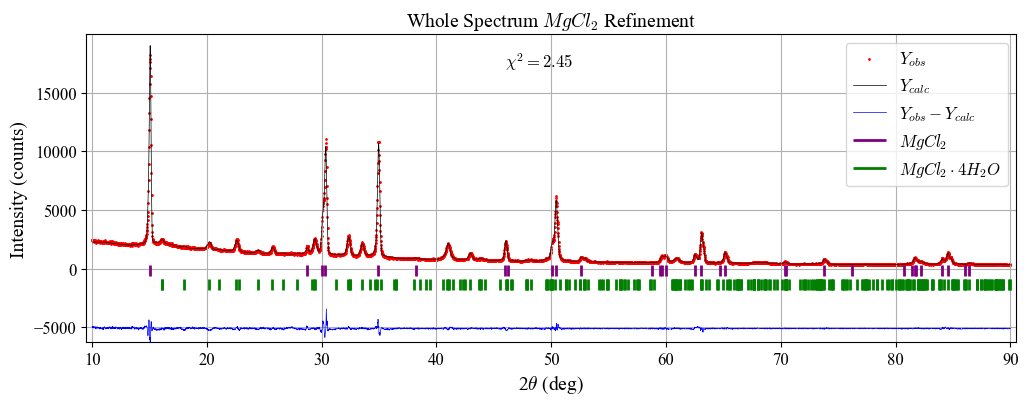

In [15]:
# Plotting cell for the full refined range. 
y_min = np.nanmin(Y_obs)
y_max = np.nanmax(Y_obs)
baseline = y_min - 0.05 * (y_max - y_min)


plt.figure(figsize=(12, 4))   # <--- key line
plt.scatter(X1, Y_obs, marker='o',s=1.0, color="red", label=r"$Y_{obs}$")
plt.plot(X2, Y_calc, color='black', label=r"$Y_{calc}$")
plt.plot(X3, Y_diff + np.min(Y_obs) * 0.05, color="blue", label=r"$Y_{obs}-Y_{calc}$")

for i in range(0, phase_amount):
    baseline_i = baseline*(1.0+i*2)
    plt.vlines(phase_data[i][3], baseline_i, baseline_i + 0.05 * (y_max - y_min), color=f"{phase_data[i][1]}", label=f"{phase_data[i][0]}", linewidths=2.0)
    
if chi2 is not None:
    ax = plt.gca()
    ax.text(
        0.45, 0.95,
        rf"$\chi^2 = {chi2:.2f}$",
        transform=ax.transAxes,
        ha="left",
        va="top",
    )

plt.xlim(9.5, 90.5)
plt.ylim(min(Y_diff + np.min(Y_obs) * 0.05), max(max(Y_obs), max(Y_calc)) * 1.05)
plt.xlabel("X")
plt.ylabel("Y (col 1)")
plt.xlabel(r"2$\theta$ (deg)")
plt.ylabel("Intensity (counts)")
plt.title(f"Whole Spectrum {phase1_name} Refinement")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


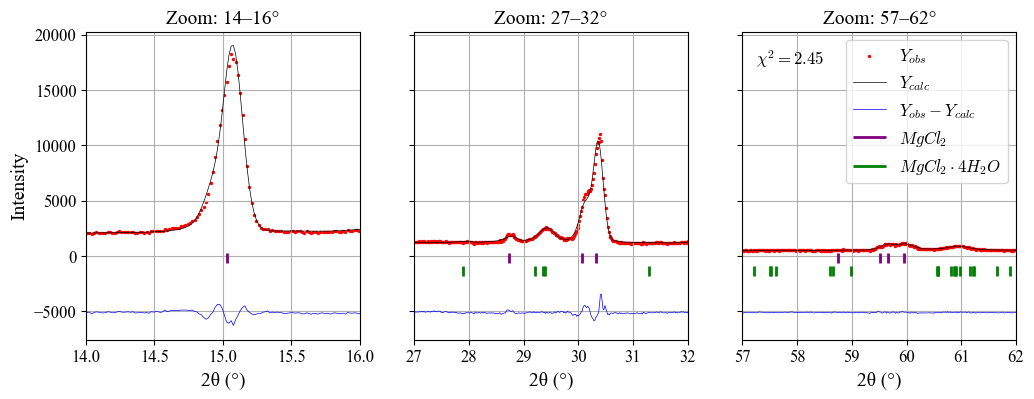

In [16]:
# Plotting cell for zoomed-in views.


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# --- Left subplot: first zoom ---
ax1.scatter(X1, Y_obs, marker='o',s=2, color="red", label=r"$Y_{obs}$")
if Y_calc is not None:
    ax1.plot(X2, Y_calc, color='black', label=r"$Y_{calc}$")
if Y_diff is not None:
    offset = np.min(Y_obs)
    ax1.plot(X3, Y_diff + offset * 0.05, color="blue", label=r"$Y_{obs}-Y_{calc}$")

ax1.set_xlim(*zoom1)
ax1.set_xlabel("2θ (°)")
ax1.set_ylabel("Intensity")
ax1.set_title(f"Zoom: {zoom1[0]}–{zoom1[1]}°")
ax1.grid(True)


# --- Right subplot: second zoom ---
ax2.scatter(X1, Y_obs, marker='o',s=2, color="red", label=r"$Y_{obs}$")
if Y_calc is not None:
    ax2.plot(X2, Y_calc, color='black', label=r"$Y_{calc}$")
if Y_diff is not None:
    offset = np.min(Y_obs)
    ax2.plot(X3, Y_diff + offset * 0.05, color="blue", label=r"$Y_{obs}-Y_{calc}$")


ax2.set_xlim(*zoom2)
ax2.set_xlabel("2θ (°)")
ax2.set_title(f"Zoom: {zoom2[0]}–{zoom2[1]}°")
ax2.grid(True)

# --- Left subplot: first zoom ---
ax3.scatter(X1, Y_obs, marker='o',s=2, color="red", label=r"$Y_{obs}$")
if Y_calc is not None:
    ax3.plot(X2, Y_calc, color='black', label=r"$Y_{calc}$")
if Y_diff is not None:
    offset = np.min(Y_obs)
    ax3.plot(X3, Y_diff + offset * 0.05, color="blue", label=r"$Y_{obs}-Y_{calc}$")

ax3.set_xlim(*zoom3)
ax3.set_xlabel("2θ (°)")
ax3.set_title(f"Zoom: {zoom3[0]}–{zoom3[1]}°")
ax3.grid(True)

for i in range(0, phase_amount):
    baseline_i = baseline*(1.0+i*2)
    ax1.vlines(phase_data[i][3], baseline_i, baseline_i + 0.05 * (y_max - y_min), color=f"{phase_data[i][1]}", label=f"{phase_data[i][0]}", linewidths=2.0)
    ax2.vlines(phase_data[i][3], baseline_i, baseline_i + 0.05 * (y_max - y_min), color=f"{phase_data[i][1]}", label=f"{phase_data[i][0]}", linewidths=2.0)
    ax3.vlines(phase_data[i][3], baseline_i, baseline_i + 0.05 * (y_max - y_min), color=f"{phase_data[i][1]}", label=f"{phase_data[i][0]}", linewidths=2.0)


if chi2 is not None:
    ax2 = plt.gca()
    ax2.text(
        0.05, 0.95,
        rf"$\chi^2 = {chi2:.2f}$",
        transform=ax2.transAxes,
        ha="left",
        va="top",
    )
# Put legend only once (on the first axes)
ax3.legend()


plt.show()